In [89]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [2]:
# jtplot.style(theme='monokai')

# Data Importing and Cleaning

### Chart Data

In [3]:
chart_df = pd.read_csv('../data/all_charts.csv')
chart_df = chart_df[['chartDate', 
                     'title', 
                     'artist', 
                     'peakPos', 
                     'lastPos',
                     'weeks',
                     'rank',
                     'change',
                     'spotifyID']]
chart_df['chartDate'] = pd.to_datetime(chart_df[('chartDate')])
chart_df['year'] = chart_df['chartDate'].dt.year
chart_df['month'] = chart_df['chartDate'].dt.month
chart_df['decade'] = (chart_df.chartDate.dt.year//10)*10
chart_df['rank_weight'] = 101 - chart_df['rank'] 

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Only keep top 10
chart_df = chart_df[chart_df['rank'] < 11]

### Spotify Data

In [5]:
spotify_df = pd.read_csv('../data/spotify_data.csv')
spotify_df = spotify_df.drop_duplicates() # remove one spotify dup
spotify_df['maj_minor'] = spotify_df['key_mode'].str.split(' ', 1).str[1]

### Lyrics Data

#### Import and clean data

In [6]:
lyrics_df = pd.read_csv('../data/lyrics.csv')
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()] # remove songs without lyrics

In [7]:
# Create TextBlob object. Extract polarity score
from textblob import TextBlob
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # converts (-1,1) score to (0,1)

#### Word Analysis

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()
word_counts.columns = ['word', 'count'] # rename columns

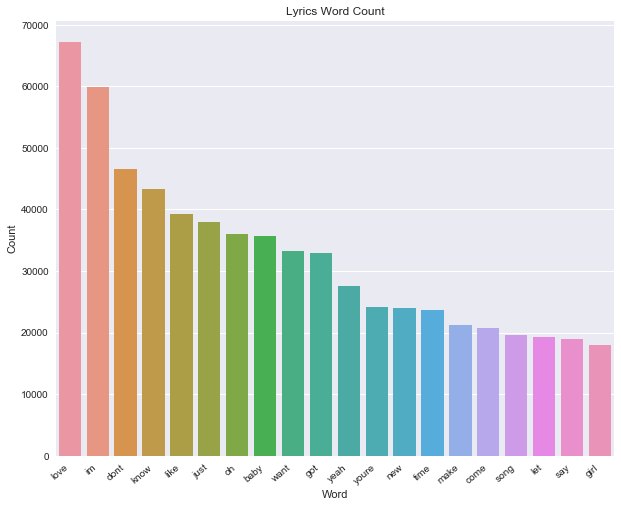

In [90]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=40, ha = 'right')
plt.title('Lyrics Word Count')
plt.show()

### Join Data

In [10]:
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')
df = pd.merge(df, lyrics_df, left_on='spotifyID', right_on = 'spotifyID', how='inner')

#### Analysis

In [11]:
import operator
def quick_filter(df, bort, peak_pos_thresh = 5):        
    """
    Function quickly subsets the data for quick data searches & avoids making temporary dataframes
    It's not perfect but it's quick and helpful
    """
    spot_flds = ['chartDate', 'title', 'artist', 'peakPos', 'valence', 'energy', 'polarity', 'happy_index']
    return df[bort & (df['peakPos'] < 5)][spot_flds].drop_duplicates(subset = ['title', 'artist'])

In [12]:
# Examples for valence v energy plot below

# quick_filter(df, (df['valence'] < .2) & (df['energy'] < .2))
# Can You Feel The Love Tonight by Elton John (142471)

# quick_filter(df, (df['valence'] > .8) & (df['energy'] < .4))
# Bang Bang (My Baby Shot Me Down) nancy sinatra

# quick_filter(df, (df['valence'] > .8) & (df['energy'] > .8))
# surfin usa beach boys, splish splash, if I had a hammer, timber pitbull + kesha, hey yah outcast

# quick_filter(df, (df['valence'] < .3) & (df['energy'] > .8))
# Like A Prayer	Madonna, My Sacrifice Creed

In [51]:
# create of energy quadrants
he_hv = df[(df['energy'] > .5) & (df['valence'] > .5) ].shape[0]
he_lv = df[(df['energy'] > .5) & (df['valence'] <= .5)].shape[0]
le_lv = df[(df['energy'] <= .5) &(df['valence'] <= .5)].shape[0]
le_hv = df[(df['energy'] <= .5) & (df['valence'] > .5)].shape[0]

[cnt / df.shape[0] for cnt in [he_hv, he_lv, le_lv, le_hv]]
def pretty_pct(quad_count, df = df):
    pct = quad_count / df.shape[0]
    pct = round(pct*100,2)
    return  str(pct) + '%'
pretty_pct(he_hv)

'55.84%'

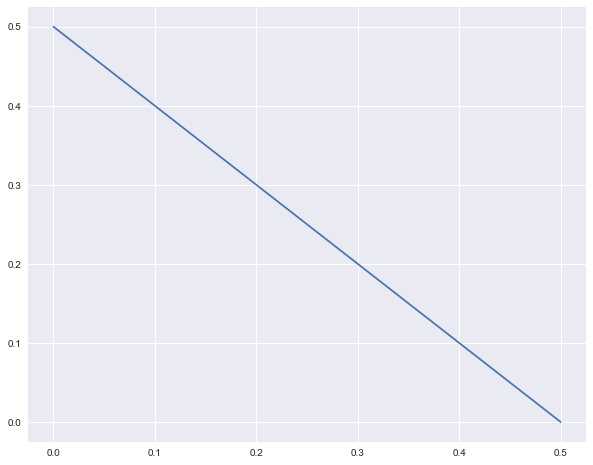

In [175]:
plt.plot(np.linspace(.5,0, 5), np.linspace(0,.5, 5))

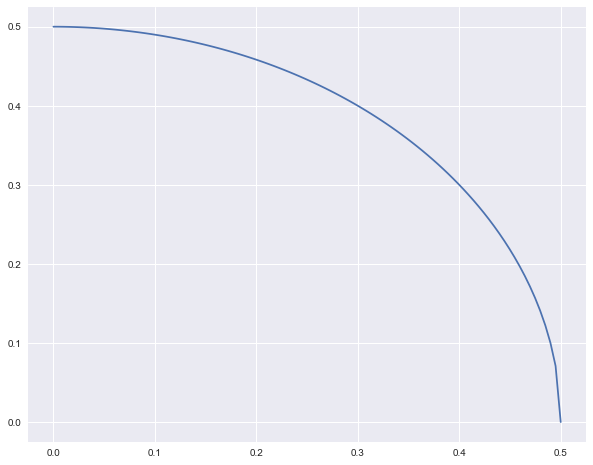

In [183]:
the_x = np.linspace(0, .5, 100)
the_y = (.25 - the_x**2)**(1/2)
plt.plot(the_x, the_y)

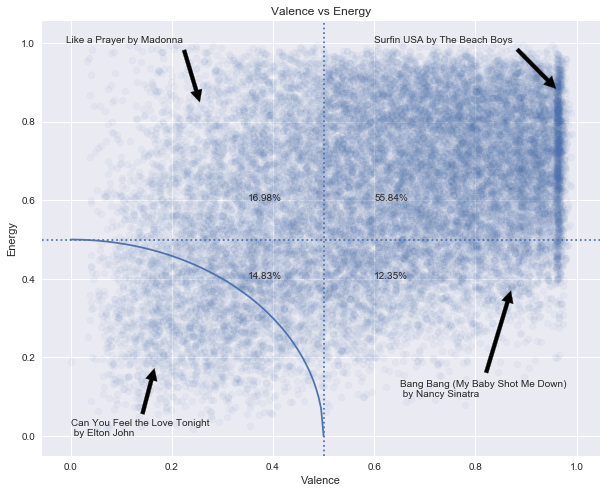

In [184]:
# Show off the differences 
plt.scatter(spotify_df['valence'], spotify_df['energy'], alpha = .05)
plt.title('Valence vs Energy')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.axvline(x=0.5, ls = 'dotted')
plt.axhline(y=0.5, ls = 'dotted')

the_x = np.linspace(0, .5, 100)
the_y = (.25 - the_x**2)**(1/2)
plt.plot(the_x, the_y)

plt.annotate('Surfin USA by The Beach Boys', xy=(0.964, 0.878), xytext = (.6,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_hv), xy=(.6,.6))

plt.annotate('Bang Bang (My Baby Shot Me Down) \n by Nancy Sinatra', xy=(0.873, 0.382), xytext = (.65,.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_hv), xy=(.6,.4))

plt.annotate('Can You Feel the Love Tonight \n by Elton John', xy=(0.1670, 0.1790), xytext = (0,0), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_lv), xy=(.35,.4))

plt.annotate('Like a Prayer by Madonna', xy=(0.2570, 0.842), xytext = (-.01,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_lv), xy=(.35,.6))

plt.show()

In [14]:
# quick_filter(df, (df['polarity'] < .4))
# Bridge Over Troubled Water \n by Simon & Garfunkel

# quick_filter(df, (df['polarity'] > .65))
# You're Beautiful by James Blunt

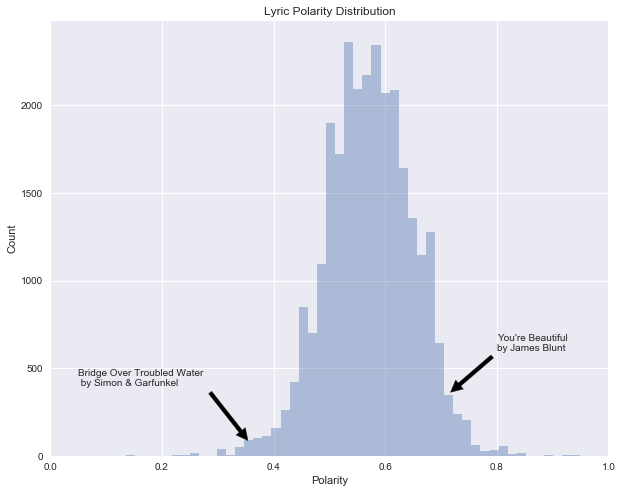

In [92]:
sns.distplot(df['polarity'], kde = False)
plt.title('Lyric Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xlim(0, 1)

plt.annotate('Bridge Over Troubled Water \n by Simon & Garfunkel', 
             xy=(0.358322, 70), 
             xytext = (.05, 400), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("You're Beautiful \nby James Blunt", 
             xy=(0.712690, 350), 
             xytext = (.8, 600), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

Create Happy_Index by combining *valence* and *energy* from Spotify with the *polarity* of the Lyrics -- while normalizing. 

In [119]:
from sklearn.metrics.pairwise import euclidean_distances
coord = df['coord'] =[[df['valence'].iloc[i], df['energy'].iloc[i]] for i in range(df.shape[0])]
df['euclidean_dist'] = euclidean_distances(coord, [[0, 0]])

df['euc_dist_normed'] = df['euclidean_dist'] / (2**(1/2)) # euclidian dist between (0,0) & (1,1)
df['happy_index'] = (df['euc_dist_normed'] + df['polarity'])/2
df['happy_flag'] = np.where(df['happy_index'] > .5, 1, 0)

In [17]:
# quick_filter(df, (df['happy_index'] < .4))
# Without You \n by Harry Nilsson 0.396429

# quick_filter(df, (df['happy_index'] > .8))
# I Feel Fine by The Beatles  0.817876

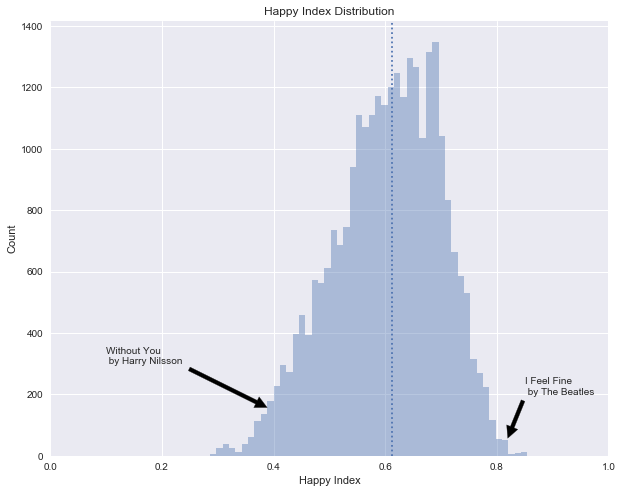

In [93]:
sns.distplot(df['happy_index'], kde = False)
plt.title('Happy Index Distribution')
plt.xlabel('Happy Index')
plt.ylabel('Count')
plt.xlim(0, 1)
plt.axvline(x = df['happy_index'].median(), ls = 'dotted') # add vertical line for the median

plt.annotate('Without You \n by Harry Nilsson', 
             xy=(0.396429, 150), 
             xytext = (.1, 300), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("I Feel Fine \n by The Beatles", 
             xy=(0.817876,50), 
             xytext = (.85, 200), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

#### Over Time

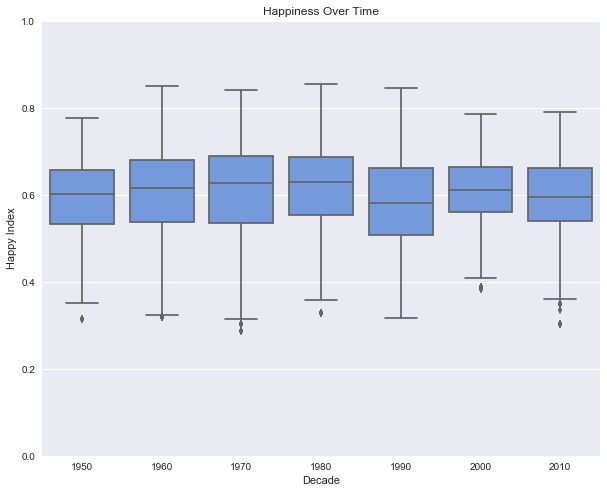

In [94]:
sns.boxplot(x = 'decade', y = 'happy_index', data = df,
            color = '#6495ED')
plt.title('Happiness Over Time')
plt.xlabel('Decade')
plt.ylabel('Happy Index')
plt.ylim(0, 1)
plt.show()

#### Missing Data

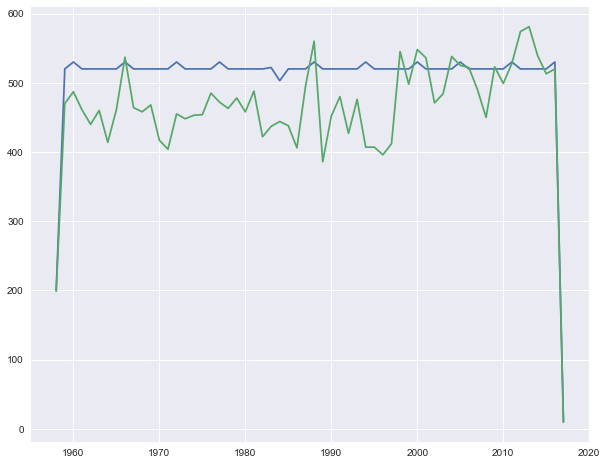

All chart totals: 30455 
Merged Dataset: 27733 
Percent Coverage: 91.06%


In [95]:
chart_year = chart_df.groupby('year')['rank'].count().reset_index(name = 'count')
df_year = df.groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year['year'], chart_year['count'])
plt.plot(df_year['year'], df_year['count'])
plt.show()
print('All chart totals: ' + str(chart_year['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year['count'].sum() / chart_year['count'].sum()*100,2)) + '%')

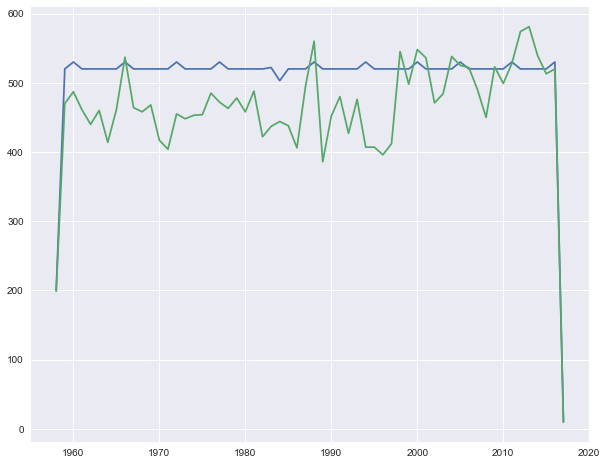

All chart totals: 30455 
Merged Dataset: 27733 
Percent Coverage: 91.06%


In [96]:
chart_year_10 = chart_df[chart_df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
df_year_10 = df[df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year_10['year'], chart_year_10['count'])
plt.plot(df_year_10['year'], df_year_10['count'])
plt.show()
print('All chart totals: ' + str(chart_year_10['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year_10['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year_10['count'].sum() / chart_year_10['count'].sum()*100,2)) + '%')

## add in external predictors

Group Bilboard to Month

In [104]:
df_month = df.groupby(['year', 'month', 'decade'])[['happy_index', 'valence', 'energy', 'polarity']].mean().reset_index()
df_month['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(df_month.month, np.ones(df_month.shape[0]).astype(int), df_month.year)]

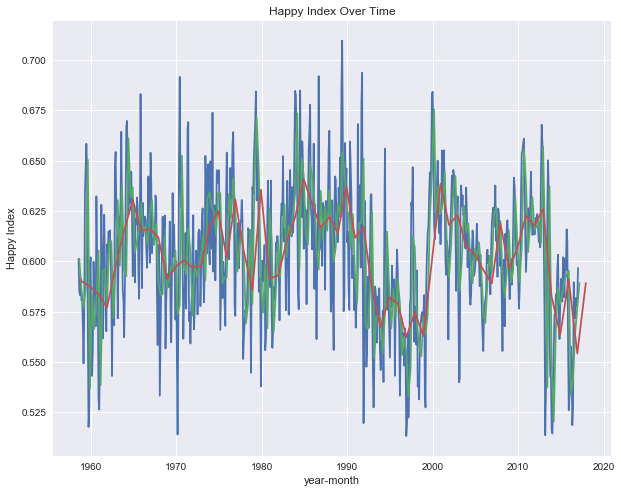

In [105]:
df_month_date = df_month.set_index('dates')

plt.plot(df_month_date['happy_index'])
plt.plot(df_month_date.resample('Q-NOV')['happy_index'].mean())
plt.plot(df_month_date.resample('A-NOV')['happy_index'].mean())

plt.title('Happy Index Over Time')
plt.xlabel('year-month')
plt.ylabel('Happy Index')
# plt.ylim(0, 1)
plt.show()

Import SnP and clean

In [106]:
snp_df = pd.read_csv('../data/daily_snp500.csv')
snp_df['Date'] = pd.to_datetime(snp_df[('Date')])
snp_df['year'] = snp_df['Date'].dt.year
snp_df['month'] = snp_df['Date'].dt.month
snp_df['Mid'] = (snp_df['High'] + snp_df['Low'])/2

In [107]:
# aggregate snp
snp_h = snp_df.groupby(['year', 'month'])['High'].max().reset_index(name = 'snp_high')
snp_l = snp_df.groupby(['year', 'month'])['Low'].min().reset_index(name = 'snp_low').drop(['year', 'month'], axis = 1)
snp_m = snp_df.groupby(['year', 'month'])['Mid'].mean().reset_index(name = 'snp_mid').drop(['year', 'month'], axis = 1)
snp_vol = snp_df.groupby(['year', 'month'])['Volume'].sum().reset_index(name = 'snp_vol').drop(['year', 'month'], axis = 1)
snp_month_df = pd.concat([snp_h, snp_l, snp_m, snp_vol], axis=1)
print(snp_h.shape[0], snp_l.shape[0], snp_m.shape[0], snp_vol.shape[0])

816 816 816 816


In [108]:
# merge snp with music data
df_month = pd.merge(df_month, snp_month_df)

Import CCI

In [109]:
# import consumer confidence index
cci_df = pd.read_csv('../data/cci.csv')
# only keep important information
cci_df = cci_df[cci_df['LOCATION'] == 'USA'][['TIME', 'Value']]
cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])
cci_df['month'] = cci_df['TIME'].dt.month
cci_df['year'] = cci_df['TIME'].dt.year
cci_df = cci_df.rename(index=str, columns = {'Value': 'cci_value'})
cci_df = cci_df.drop('TIME', axis = 1)

In [110]:
# merge cci with music data
df_month = pd.merge(df_month, cci_df)

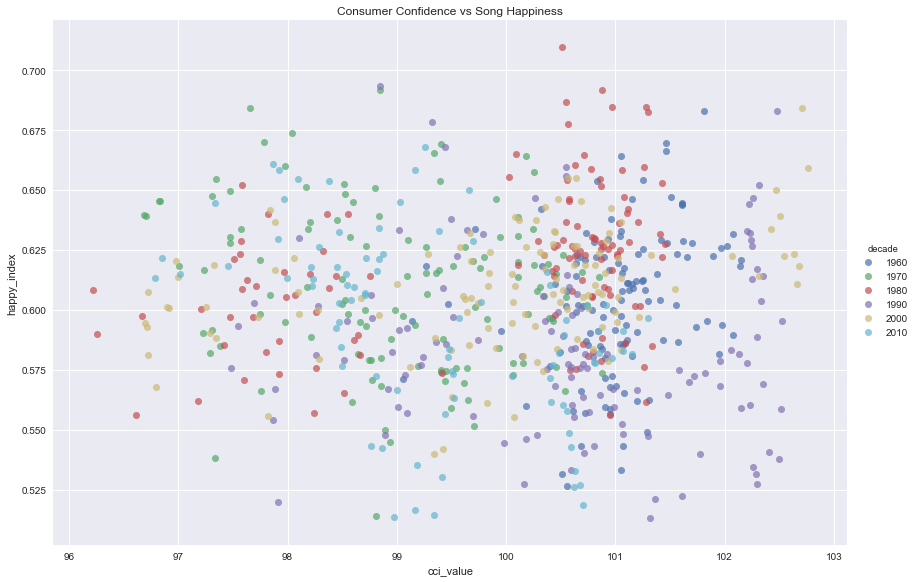

In [111]:
# sns.regplot(x="cci_value", y="happy_index", data=df_month)
sns.lmplot(x = "cci_value", 
           y = "happy_index", 
           data = df_month,
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})
plt.title('Consumer Confidence vs Song Happiness')
plt.show()

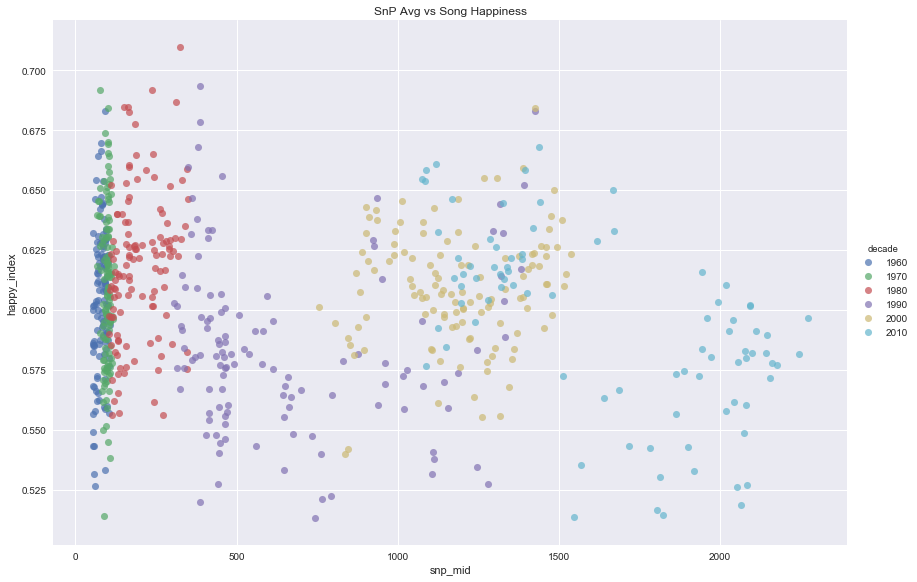

In [112]:
sns.lmplot(x="snp_mid", 
           y="happy_index", 
           data=df_month, 
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})

plt.title('SnP Avg vs Song Happiness')
plt.show()

In [118]:
def your_financial_situation(has_job, have_unlimited_money, are_sexy):
    if has_job == False and have_unlimited_money == False:
        for i in range(50):
            print("Oh shit, you're poor.")
            if are_sexy == True:
                print("But you're sexy.")
        return
    print("You're all good.")
your_financial_situation(has_job = False, have_unlimited_money = False, are_sexy = True)

Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But you're sexy.
Oh shit, you're poor.
But

AttributeError: 'Series' object has no attribute 'idx'

In [211]:
flag_df = df[df['happy_flag'] == 0].groupby(['year', 'month'])['valence'].count().reset_index(name = 'count')
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]
flag_df = flag_df.set_index('dates')

In [214]:
# super cool but pointless
# flag_df.reindex(df_month.dates, fill_value=0)['count'].sum()

0


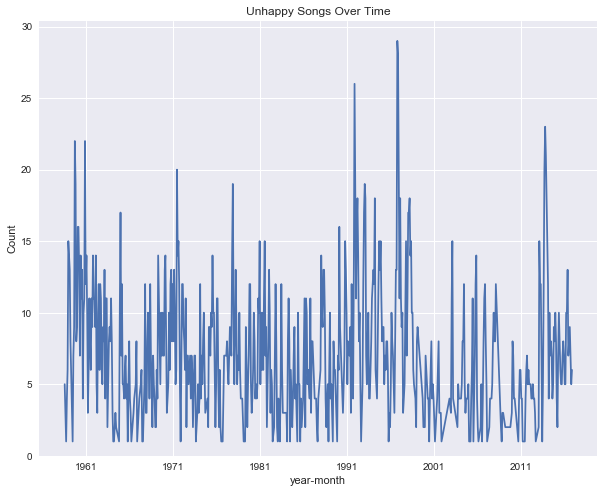

In [213]:
print(flag_df[flag_df['count'] == 0].shape[0])

plt.plot(flag_df['count'])
# plt.plot(flag_df.resample('Q-NOV')['count'].mean())
# plt.plot(flag_df.resample('A-NOV')['count'].mean())

plt.title('Unhappy Songs Over Time')
plt.xlabel('year-month')
plt.ylabel('Count')
plt.ylim(0)
plt.show()

In [ ]:
flag_df = df[df['happy_flag'] == 0].groupby(['year', 'month'])['valence'].count().reset_index(name = 'count')

In [ ]:
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]


# plt.plot(ddd.set_index('dates')['valence'])
flag_df = flag_df.set_index('dates')
plt.plot(flag_df['count'])

When will a somber song succeed

5 months smoothing

In [34]:
quick_filter(df, (df['title'] == 'Turn Down For What'))

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
26385,2014-04-12,Turn Down For What,DJ Snake & Lil Jon,4,0.0815,0.799,0.467901,0.517906


In [192]:
quick_filter(df, (df['happy_index'] < .5))

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
16,1958-08-16,My True Love,Jack Scott,3,0.2140,0.1890,0.678234,0.440061
209,1958-12-20,Smoke Gets In Your Eyes,The Platters,1,0.2160,0.2790,0.690909,0.470203
237,1959-01-10,My Happiness,Connie Francis,2,0.3280,0.2880,0.567370,0.438009
251,1959-01-24,Donna,Ritchie Valens,2,0.3940,0.2240,0.580861,0.450670
269,1959-01-24,Stagger Lee,Lloyd Price,1,0.5970,0.3990,0.482606,0.495176
324,1959-03-14,It's Just A Matter Of Time,Brook Benton,3,0.4800,0.1600,0.616204,0.486987
518,1959-08-22,The Three Bells,The Browns,1,0.4260,0.1380,0.550316,0.433477
535,1959-08-29,Sleep Walk,Santo & Johnny,1,0.4830,0.2250,0.403896,0.390334
573,1959-09-26,Put Your Head On My Shoulder,Paul Anka,2,0.4740,0.3350,0.560741,0.485584
592,1959-10-10,Mr. Blue,The Fleetwoods,1,0.2110,0.0889,0.541194,0.351548
